<h1>Import libraries needed

In [2]:
import numpy as np
import keras
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import holidays
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loads the data into a data frame, beneficial to have in a separate line as it takes some time to load. I skip the first 17545 lines as they do not contain load values

In [3]:
#Hourly data for load
data = pd.read_excel('GEFcom2014Data/GEFCom2014-E.xlsx', skiprows =range(1,17545))

Data transformation to normalize data

In [4]:
data['month'] = np.cos(2*np.pi*data.Date.dt.month / 12)
data['dow'] = np.cos(2*np.pi*data.Date.dt.dayofweek / 7)
data['hour'] = np.cos(2*np.pi*data.Date.dt.hour/24)
us_holiday = holidays.US()
data['is_holiday'] = 1 * data.Date.dt.date.apply(lambda x: x in us_holiday)
data.drop(['Date', 'Hour'],1, inplace=True)
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
c = list(data.columns)
c = c[1:] + c[:1]
data = data[c]
data['CDD'] =  np.maximum(data.Temperature-65,0)
data['HDD'] = np.maximum(65 - data.Temperature,0)
scale = data.load.std()
offset = data.load.mean()
data.load = (data.load - offset) / scale

Data divided into Input and Target

In [5]:
dataInput= data.drop('load', axis = 1)
dataTarget = data['load']

Cross validating data so we have more data points and randomness in our Test and Train sets

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataInput,dataTarget, test_size=0.2, shuffle = True)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(63110, 7)
(63110,)
(15778, 7)
(15778,)


Text(0,0.5,'Error')

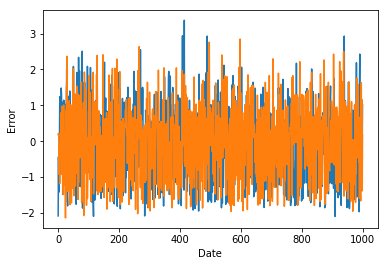

In [17]:
plt.plot(y_train[:1000])
plt.plot(y_test[:1000])
plt.xlabel("Date")
plt.ylabel("Error")


Makes the data sequential. The future predicts the horizons. History goes back in time

In [18]:
#xf is x values with future values
#yf is y values with future values
def create_dataset(data, yValues, history=24, future = 0):
    x = []
    xf = []
    y = []
    yf = []
    for i in np.arange(history+1, len(data)-max(future,1)):
        a = data[i-history:i+1]
        b= yValues[i-history-1:i].reshape(-1,1)
        x.append(np.append(a, b, axis=1))
        xf.append(data[i+1:i+future+1])
        y.append(yValues[i])
        yf.append(yValues[i:i+future])
    return np.array(x), np.array(xf), np.array(y), np.array(yf)

In [19]:
#xt = xtrain, xtf= xtrain future, yt = ytrain, ytf = ytrainfuture
#xtt = xtest, xttf = xtest future, ytt = ytest, yttf = ytestfuture
xt, xtf, yt, ytf = create_dataset(x_train, y_train, history=24, future=1)
xtt, xttf, ytt, yttf = create_dataset(x_test, y_test, history=24, future=1)

In [20]:
#pinball loss function that's called by model.compile
#K makes it a tensor so that it can be called by the 
def pinball(y_true, y_pred, step =1):
#     tau = K.arange(step, 100, step, dtype=np.float32)/100  #creates 99 quantiles
    tau = [0.2,0.7]
    tau = K.reshape(tau,(1,-1))
    y_true = K.reshape(y_true,(-1,1))
    a = K.maximum(y_true - y_pred, 0) * tau
    b = K.maximum(y_pred - y_true, 0) * (1 - tau)
    pin = K.mean(a+b)
    return pin

Creates model. Changing layer numbers, hiddenUnits

In [21]:
layer = 1
hiddenU = 16
val_dictionary = {}
model = keras.models.Sequential(name = 'LSTM')
model.add(keras.layers.LSTM(hiddenU, input_shape = xt.shape[1:], return_sequences = layer > 1))

#The for loop adds more layers

# for i in range(layer-1):
#     model.add(keras.layers.LSTM(hiddenU, return_sequences = i < layer-2))

#changing Dense values increases output layers. Changing 2 to 99 would give you 99 outputs. 
model.add(Dense(2))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)

model.compile(loss= lambda y, yp: (pinball(y, yp, 1)), optimizer = 'adam')

Trains model weights. Early stopping prevents overtraining. Stops training the model if loss stops decreasing.

In [22]:
# hist = model.fit(xt, yt, batch_size=768, epochs=100,validation_split=0.1, verbose=1, callbacks=[keras.callbacks.ModelCheckpoint(
# 'Weights/LSTMWeights', save_best_only=True, save_weights_only=True)
#   , keras.callbacks.EarlyStopping(patience=20)])
# best_val = min(hist.history['val_loss'])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 1,634
Trainable params: 1,634
Non-trainable params: 0
_________________________________________________________________


In [24]:
#loads  pretained weights to the model. Need to run cell which creates the model first
model.load_weights('Weights/LSTMGetWeights')

The for loop returns the weights

In [27]:
for layer in model.layers:
    weights = layer.get_weights()
print(weights)

[array([[ 0.35      , -0.25284126],
       [ 0.37837738, -0.5382352 ],
       [-0.05943123,  0.19144805],
       [ 0.3131915 ,  0.7109782 ],
       [ 0.23572737, -0.11478594],
       [ 0.10371532,  0.6173115 ],
       [ 0.9760161 ,  1.4972438 ],
       [ 0.2379393 , -0.0071888 ],
       [ 0.55228376,  0.46662283],
       [ 1.2852958 ,  0.475782  ],
       [ 0.13585456,  0.5095823 ],
       [-0.13454953, -0.7498165 ],
       [ 0.00282927, -0.53929615],
       [-0.21484761,  0.08239145],
       [ 0.9378741 ,  0.8509973 ],
       [-0.46459877,  0.21304554]], dtype=float32), array([-0.01857078,  0.26882732], dtype=float32)]


The following code sets custom weights. Have to make sure it is the same size array as that returned by get weights. Additionally, need to make sure to call np.array and np.float

In [26]:
layer.set_weights([np.array([[ 0.35000, -0.25284126],
       [ 0.37837738, -0.5382352 ],
       [-0.05943123,  0.19144805],
       [ 0.3131915 ,  0.7109782 ],
       [ 0.23572737, -0.11478594],
       [ 0.10371532,  0.6173115 ],
       [ 0.9760161 ,  1.4972438 ],
       [ 0.2379393 , -0.0071888 ],
       [ 0.55228376,  0.46662283],
       [ 1.2852958 ,  0.475782  ],
       [ 0.13585456,  0.5095823 ],
       [-0.13454953, -0.7498165 ],
       [ 0.00282927, -0.53929615],
       [-0.21484761,  0.08239145],
       [ 0.9378741 ,  0.8509973 ],
       [-0.46459877,  0.21304554]], dtype=np.float32), np.array([-0.01857078,  0.26882732], dtype=np.float32)])

The creates predictions

In [28]:
preds = model.predict(xtt, batch_size= 768)

Converts the predictions into an array. And reshapes them to be in the order required to be parallel with the target values

The reshape of predictions is based on the number of predictions expected (target_used), horizion, and quantiles

In [30]:
prediction = np.array(preds)
prediction = prediction.reshape(15752,1,2) #you can make it variable

In [31]:
target_used = yttf 
target_used.shape

(15752, 1)

The code below is used to created a list of the pin ball scores and bins for the QCS

In [17]:
count_list = []
pin_list = []
# bins = [-1,1,10,20,30,40,50,60,70,80,90,99,101]
bins = [-1,1,2,3,4,5,6,7,8,9,10]
for hour in range(1):
#     ts = (np.arange(1, 100,10, dtype=np.float32)/100).reshape(1,-1)
#     ts = (np.arange(1, 100, 1, dtype=np.float32)/100).reshape(1,-1)
    tau = [0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]
    for  tau in  tau:
        b = np.maximum(target_used[:,hour,None] - prediction[:,hour,:], 0) * (1 -  tau)
        a = np.maximum(prediction[:,hour,:] - target_used[:,hour,None], 0) *  tau
        pin = np.mean(a+b)
        pin_list.append(pin*scale)
    counts, bins = np.histogram((prediction[:,hour,:]>target_used[:,hour,None]).sum(1), bins=bins)
    count_list.append(counts)
    print(count_list)
    print("Pin list", pin_list)
    print('iteration for time %d' %hour)
    
count_array = np.array(count_list)

[array([4832, 7711, 3209,    0,    0,    0,    0,    0,    0,    0])]
Pin list [303.31153588832336, 293.74891311927973, 284.1862903502362, 274.62366758119265, 265.06104481214913, 255.49842204310553, 245.93579927406202, 236.37317650501845, 226.81055373597493, 217.2479309669314]
iteration for time 0


Qcs score calculation

In [20]:
np.mean(pin_list)

260.2797334276273

In [18]:
def qcs(expected, observed):
    return ((observed-expected)**2/expected/len(expected)).sum(0)


n_examples = count_array.sum(1)[0]

prob_bins = np.array([0.1,0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
for i in range(1):
    print(qcs(prob_bins*n_examples, count_array[i]))

4335.505053326562


Creates the GCS

(-0.5125, 9.4875)

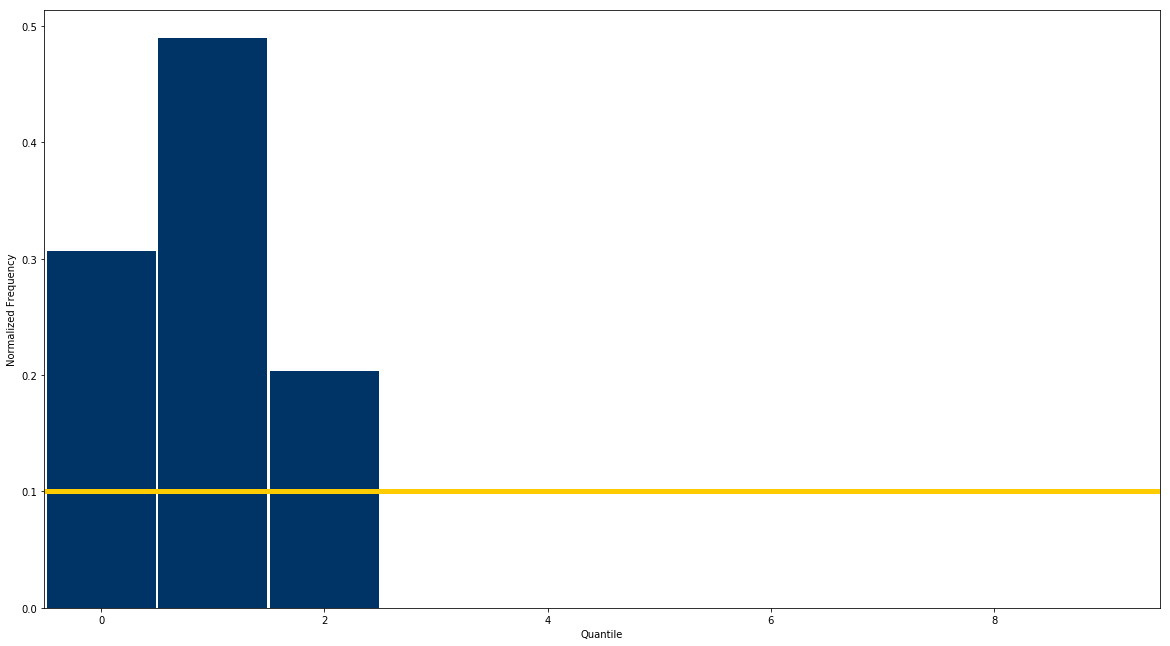

In [19]:
plt.figure(figsize=(20,11))
t = 0
plt.bar(np.arange(10), count_array.sum(0)/count_array.sum(), width=0.975, align='center', color = '#003366' )
# plt.xticks(range(10), [f'{i}% - {i+10}%' for i in range(0,110,10)])
plt.xlabel('Quantile')
plt.ylabel('Normalized Frequency')
# plt.plot((-0.6, 0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((11-0.6, 11+0.6), (0.01, 0.01), color='r', lw=3)
# plt.plot((1-0.6, 1+0.6), (0.09, 0.09), color='r', lw=3)
# plt.plot((10-0.6, 10+0.6), (0.09, 0.09), color='r', lw=3)
# plt.ylim(0,.045)
for i in range(0,10):
    plt.plot((i-0.6, i+0.6), (0.1, 0.1), color='#FFCC00', lw=3)
plt.plot((-100000, 100000), (0.1, 0.1), color='#FFCC00', lw=5)
plt.xlim(-0.5 - 0.025/2,9.5- 0.025/2)